In [7]:
import numpy as np
import pandas as pd
import json 
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS,CountVectorizer
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import CoherenceModel
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

In [2]:
def build_df(annies_lst):
    df = pd.DataFrame(data = annies_lst, columns = ['year','season','month','state','county'])
    return df

def clean_function(value):
    for idx, val in enumerate(value):
        if val == ':':
            return(value[idx+2:])

def get_article(article):
    soup = BeautifulSoup(article['html'], 'lxml')
    table = soup.find('table', id='Table1')
    info = table.findAll('p')
    i = 0
    year = 0
    season = 0
    month = 0
    state = 0
    county = 0
    while i < len(info) and (year == 0 or season == 0 or month == 0 or state == 0 or county == 0):
        if info[i].get_text() == '':
            i+=1
        elif info[i].get_text()[0] == 'Y':
            year = clean_function(info[0].get_text())
            i += 1 
        elif info[i].get_text()[0:2] == 'SE':
            season = clean_function(info[i].get_text())
            i += 1 
        elif info[i].get_text()[0] == 'M':
            month = clean_function(info[i].get_text())
            i += 1 
        elif info[i].get_text()[0:2] == 'ST':
            state = clean_function(info[i].get_text())
            i += 1 
        elif info[i].get_text()[0] == 'C':
            county = clean_function(info[i].get_text())
            i += 1
        else:
            i += 1
    return [year, season, month, state, county]

def get_content(article):
    soup = BeautifulSoup(article['html'], 'lxml')
    table = soup.find('table', id='Table1')
    # index = int(re.search(r'\d+', (table.find('span', class_='reportheader').get_text())).group())
    index = article['_id']['$oid']
    info = table.findAll('p')
    content = ''
    for i in range(len(info)+1):
        try:
            content += clean_function(info[i].get_text())
        except:
            continue
    try:
        block = table.find('blockquote').get_text().strip('\n')
        content + block
    except:
        return index, content
    return index, content

def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [3]:
    file_path = 'data/bigfoot_first100records.json'
    file_path2 = 'data/bigfoot_data.json'
    records = []
    with open(file_path2) as f:
        for i in f:
            records.append(json.loads(i))
    soup = BeautifulSoup(records[0]['html'], 'lxml')
    keywords = soup.find('meta', {'name':"KEYWORDS"})
    keywords['content']
    content = soup.find

    # all_data = {}
    # for i in range(len(records)):
    #     index, data = get_article(records[i])
    #     all_data[index]= data

    all_content = {}
    for i in range(len(records)):
        index, content = get_content(records[i])
        all_content[index] = content

    corpus = []
    for i in range(len(records)):
        index, content = get_content(records[i])
        corpus.append(content)

    val = []
    for num in range(len(records)-1):
        b = get_article(records[num])
        val.append(b)
    df = build_df(val)

    #TODO stem/lemmatize
    stop_words =set()
    stop_words = stop_words.union({'just', 'like', 'did', 'time', 'saw', 'right', 'left', 
                                            'road', 'county', 'year', 'road','said', 'area', 'nt',
                                            'woods', 'heard', '2009', '2012', '2011', '2013', '2009', 'km',
                                            '07', '09', 'didnt'})
    stop_words = stop_words.union(set(df['year']))
    stop_words = stop_words.union(set(df['season']))
    stop_words = stop_words.union(set(df['month']))
    stop_words = stop_words.union(set(df['state']))
    stop_words = stop_words.union(set(df['county']))
    stop_words =ENGLISH_STOP_WORDS.union(stop_words)
    
    #tokenized = [word_tokenize(content.lower()) for content in documents]


    vectorizer = TfidfVectorizer(stop_words = 'english')
    X = vectorizer.fit_transform(corpus)
    tfidf_words = vectorizer.get_feature_names()

    countvect = CountVectorizer(stop_words=stop_words)
    count_vectorized = countvect.fit_transform(corpus)
    words_count = countvect.get_feature_names()

    lda = LatentDirichletAllocation(n_components= 20, max_iter=5, learning_method='online',random_state=0, n_jobs=-1)
    lda.fit(count_vectorized)
    num_top_words = 8
    display_topics(lda, words_count, num_top_words)

Topic 0:
blacktop loup chopaka spouse honobia madawaska leflore rochester
Topic 1:
trailer dogs barking cemetery house clark alberta coon
Topic 2:
82 cle elum richmond woodlot milton shawnee lighthouse
Topic 3:
princeton packwood 9th greenwater alders ottawa hatchery landlord
Topic 4:
boat bus baker rainier dock ramp trapper kilometers
Topic 5:
cabin swamp cabins boys ron organized whoop footage
Topic 6:
manitoba winnipeg sammamish fairford easterville blueberries gypsumville cyndi
Topic 7:
creature hair tall car witness feet looked animal
Topic 8:
ky ginseng cody snuff kalama tallik cages shall
Topic 9:
monroe metres tbrc wich kelly paddling warden researched
Topic 10:
walla brenda blacksnake steped needing rawley hoop forge
Topic 11:
raymond campbell warren cabbage sac definetly mate pecan
Topic 12:
stan scott training garage graveyard maine sheriff columbia
Topic 13:
darrington salmonberry molalla walter naches arlington 16276 23170
Topic 14:
skookum natives barrens pas pinchot chin

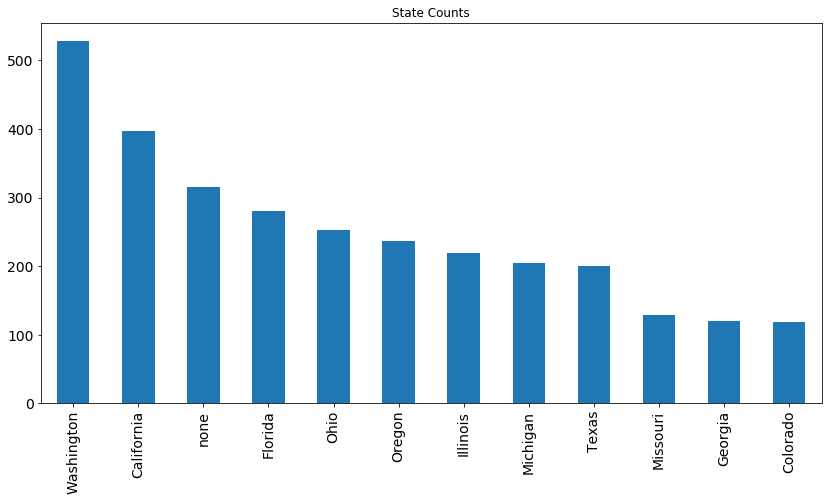

In [4]:
df['state'].replace(0,'none').value_counts()[:12].plot(kind='bar',figsize =(14,7),title = 'State Counts',fontsize=14)

In [4]:
df['month'].replace(0,'none').value_counts().plot(kind='bar',figsize =(14,7),title = 'Month Counts',fontsize=14)

/home/alec/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/alec/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/alec/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 147 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/alec/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/alec/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 133 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/alec/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: 

ValueError: Image size of 828x88508 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1008x504 with 1 Axes>

In [11]:
df['month'].value_counts()

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

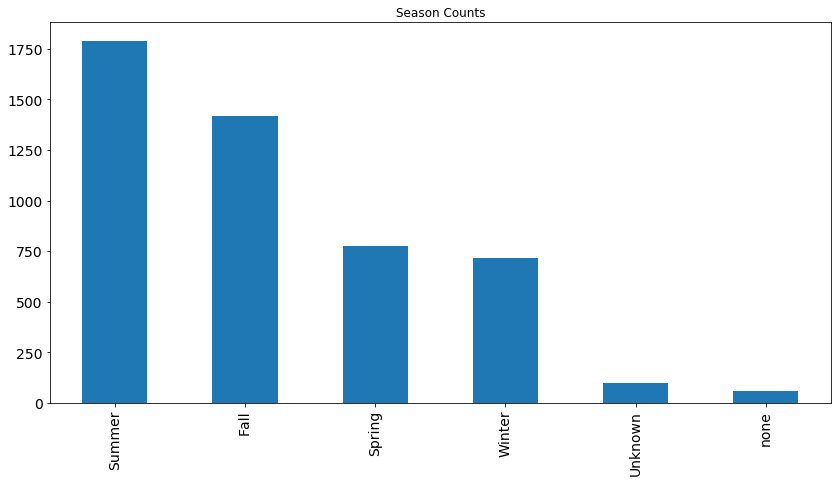

In [5]:
df['season'].replace(0,'none').value_counts().plot(kind='bar',figsize =(14,7),title = 'Season Counts',fontsize=14)

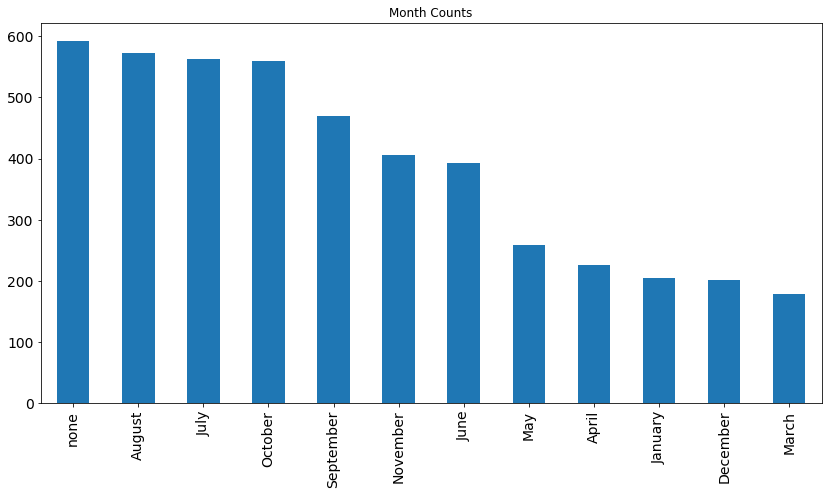

In [13]:
df['month'].replace({0:'none', 1: 'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}).value_counts()[:12].plot(kind='bar',figsize =(14,7),title = 'Month Counts',fontsize=14)

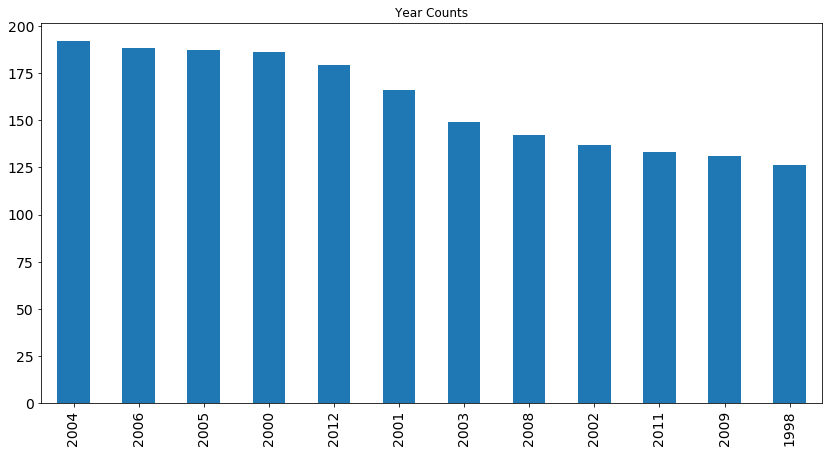

In [14]:
df['year'].replace(0,'none').value_counts()[:12].plot(kind='bar',figsize =(14,7),title = 'Year Counts',fontsize=14)

In [1]:
df['state'].replace(0,'none').value_counts()[:12].plot(kind='bar',figsize =(14,7),title = 'State Counts',fontsize=14)

NameError: name 'df' is not defined

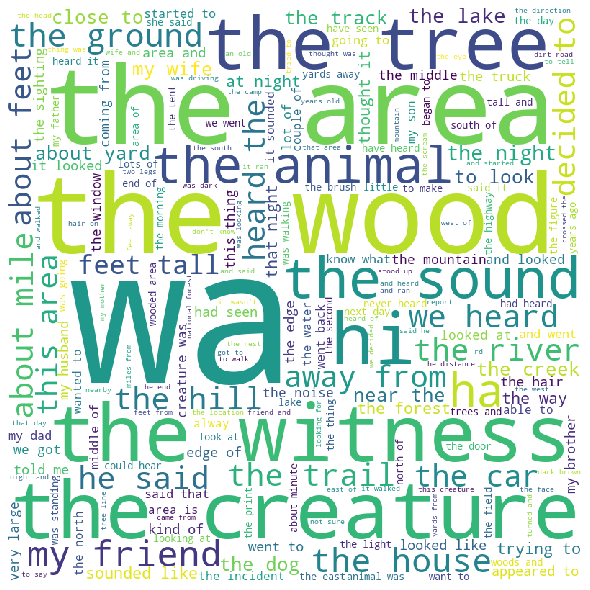

In [8]:
file_path = 'data/bigfoot_data.json'
stop_words = ENGLISH_STOP_WORDS.union({'just', 'like', 'did', 'time', 'saw', 'right', 'left', 'road', 'county', 'year', 'road'})
all_records = []
with open(file_path) as f:
    for i in f:
        all_records.append(json.loads(i))
corpus = []
for i in range(len(all_records)):
    index, content = get_content(all_records[i])
    corpus.append(content)
comment_words = ''
for val in corpus: 
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split() 
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(comment_words) 
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig('wordcloud_all.png', dpi=80)

In [9]:
x = df['year'].replace(0,'none').value_counts()[:12]

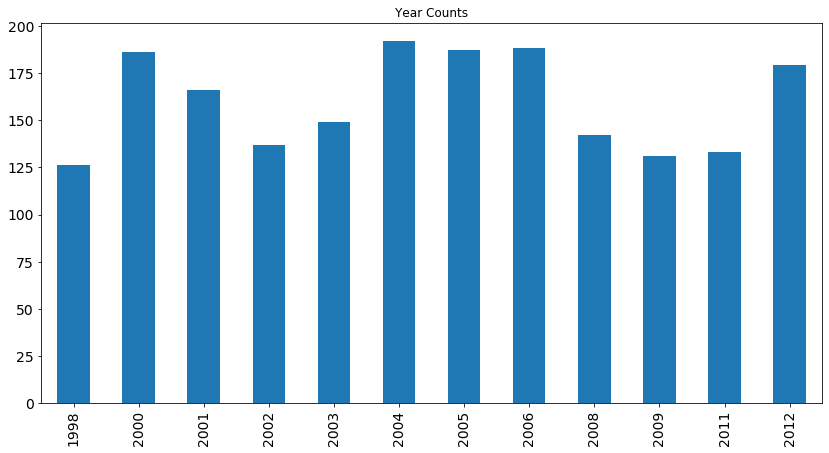

In [11]:
x.reindex(["1998", "2000","2001","2002",'2003',"2004","2005","2006","2008","2009","2011","2012"]).plot(kind='bar',figsize =(14,7),title = 'Year Counts',fontsize=14)